In [1]:
import sys
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time

In [2]:
load_dotenv()
work_dir = os.getenv('WORK_DIR')

sys.path.append(work_dir)

print('Workdir: ', work_dir)

Workdir:  /Users/carol/Documents/etl/workshop-02


In [3]:
df = pd.read_csv('../data/the_grammy_awards.csv',sep=',', encoding='utf-8')

Este dataset tiene 4810 filas y 10 columnas

In [4]:
df.shape

(4810, 10)

## Columnas del Dataset

1. **year**: El año en que se celebró la ceremonia de los GRAMMYs para la cual se registran los datos.

2. **title**: El título de la ceremonia de los GRAMMYs del año correspondiente. 

3. **published_at**: La fecha y hora en que se publicó la información sobre la ceremonia o los resultados en la base de datos. Tiene un formato de fecha y hora con zona horaria.

4. **updated_at**: La fecha y hora en que se actualizó por última vez la información en la base de datos. También en formato de fecha y hora con zona horaria. 

5. **category**: La categoría del premio GRAMMY. 

6. **nominee**: El nombre de la canción, el álbum, individuo, etc nominado para el premio en esa categoría.

7. **artist**: El nombre del artista. 

8. **workers**: Los miembros del equipo de producción que contribuyeron a la obra nominada..

9. **img**: Un enlace a una imagen asociada al nominado.

10. **winner**: Un valor booleano (True/False) que indica si la obra mencionada ganó el premio en esa categoría. 


In [146]:
df.columns

Index(['year', 'title', 'published_at', 'updated_at', 'category', 'nominee',
       'artist', 'workers', 'img', 'winner'],
      dtype='object')

Hay columnas que en realidad no son de nuestro interés, como lo son published_at y updated_at. Podemos eliminarlas:

In [4]:
df = df.drop(columns=['published_at', 'updated_at'])

Primer vistazo a nuestro dataset:

In [41]:
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


No hay duplicados:

In [147]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape[0])

number of duplicate rows:  0


## Data missing

In [148]:
missing_data = df.isna().sum()
missing_data

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist          1840
workers         2190
img             1367
winner             0
dtype: int64

Los 6 valores nulos de los nominee no tienen la columna artist, workers ni img. No sabemos casi nada acerca del nominado. 

In [10]:
df[df['nominee'].isna()]

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
2261,2000,43rd Annual GRAMMY Awards (2000),2017-11-28T00:03:45-08:00,2019-09-10T01:11:09-07:00,"Remixer of the Year, Non-Classical",NaN,NaN,NaN,NaN,True
2359,1999,42nd Annual GRAMMY Awards (1999),2017-11-28T00:03:45-08:00,2019-09-10T01:09:02-07:00,"Remixer Of The Year, Non-Classical",NaN,NaN,NaN,NaN,True
2454,1998,41st Annual GRAMMY Awards (1998),2017-11-28T00:03:45-08:00,2019-09-10T01:08:19-07:00,"Remixer Of The Year, Non-classical",NaN,NaN,NaN,NaN,True
2547,1997,40th Annual GRAMMY Awards (1997),2017-11-28T00:03:45-08:00,2019-09-10T01:07:37-07:00,"Remixer Of The Year, Non-Classical",NaN,NaN,NaN,NaN,True
4525,1965,8th Annual GRAMMY Awards (1965),2017-11-28T00:03:45-08:00,2019-09-10T01:06:59-07:00,Best New Country & Western Artist,NaN,NaN,NaN,NaN,True
4573,1964,7th Annual GRAMMY Awards (1964),2017-11-28T00:03:45-08:00,2019-09-10T01:06:11-07:00,Best New Country & Western Artist Of 1964,NaN,NaN,NaN,NaN,True


Podemos eliminar estos 6 registros.

In [5]:
df = df.dropna(subset=['nominee'])

Ahora, si vemos los demás nulos y de qué categoría son:

In [6]:
df_nulos = df[df['artist'].isna() | df['workers'].isna()]

nulos_por_categoria = df_nulos.groupby('category').agg(
    nulos_artist=('artist', lambda x: x.isna().sum()),
    nulos_workers=('workers', lambda x: x.isna().sum())
)

nulos_por_categoria['total_nulos'] = nulos_por_categoria['nulos_artist'] + nulos_por_categoria['nulos_workers']
nulos_ordenados = nulos_por_categoria.sort_values(by='total_nulos', ascending=False)

nulos_ordenados

,nulos_artist,nulos_workers,total_nulos
category,,,
Best New Artist,50,51,101
Song Of The Year,70,0,70
Best Opera Recording,64,0,64
Best Album Notes,63,0,63
Best Instrumental Composition,55,0,55
...,...,...,...
Best Pop Vocal Performance By A Group,0,1,1
Best Dance Recording,0,1,1
"Best Country Vocal Solo Performance, Male",0,1,1


A pesar de que ya sabemos que dependiendo de la categoría hay nulos en determinadas columnas, podemos extraer el artista de la columna workers, dato que se encuentra entre paréntesis. Necesitamos esto ya que haremos un merge y el dato de artista lo necesitamos para el merge con el dataset de spotify.

In [42]:
df[df['nominee']=='Lover']

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
20,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Song Of The Year,Lover,NaN,"Taylor Swift, songwriter (Taylor Swift)",https://www.grammy.com/sites/com/files/styles/...,True
51,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Best Pop Vocal Album,Lover,Taylor Swift,NaN,https://www.grammy.com/sites/com/files/styles/...,True


Este código nos permite extraer aquello que está entre paréntesis en workers:

In [6]:
extracted_artists = df['workers'].str.extract(r'\(([^)]+)\)', expand=False)
df['artist'] = df['artist'].fillna(extracted_artists)

## Data type

### Datos Cuantitativos
Valores numéricos que se pueden medir y analizar estadísticamente.
- **year**: int64

### Datos Cualitativos
Datos descriptivos que representan categorías o características.
- **title**: object
- **published_at**: object
- **updated_at**: object
- **category**: object
- **nominee**: object
- **artist**: object
- **workers**: object
- **img**: object
- **winner**: bool

In [150]:
df.dtypes

year             int64
title           object
published_at    object
updated_at      object
category        object
nominee         object
artist          object
workers         object
img             object
winner            bool
dtype: object

Aseguremonos que las cadenas de texto estén en el mismo formato

In [7]:
df.loc[:, 'title'] = df['title'].str.title().str.strip()
df.loc[:, 'category'] = df['category'].str.title().str.strip()
df.loc[:, 'nominee'] = df['nominee'].str.title().str.strip()
df.loc[:, 'artist'] = df['artist'].str.title().str.strip()
df.loc[:, 'workers'] = df['workers'].str.title().str.strip()

## Data Distribution

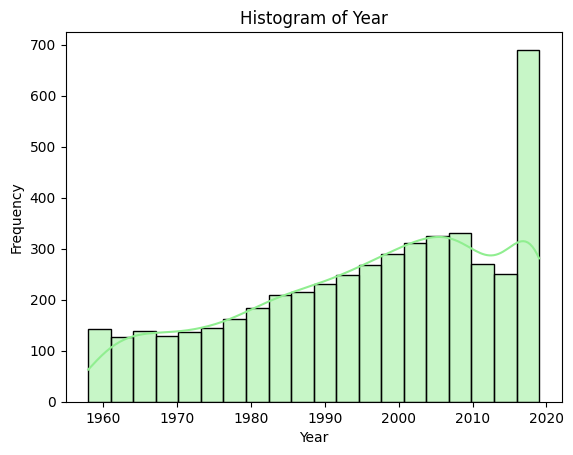

In [13]:
sns.histplot(df['year'], kde=True, bins=20,color='lightgreen')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Year')
plt.show()
    

### Outliers

No hay outliers

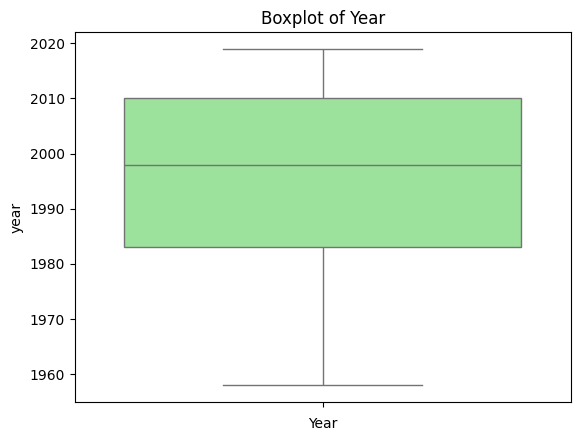

In [15]:
sns.boxplot(y=df['year'], color='lightgreen')
plt.xlabel('Year')
plt.title('Boxplot of Year')
plt.show()

## Data Patterns

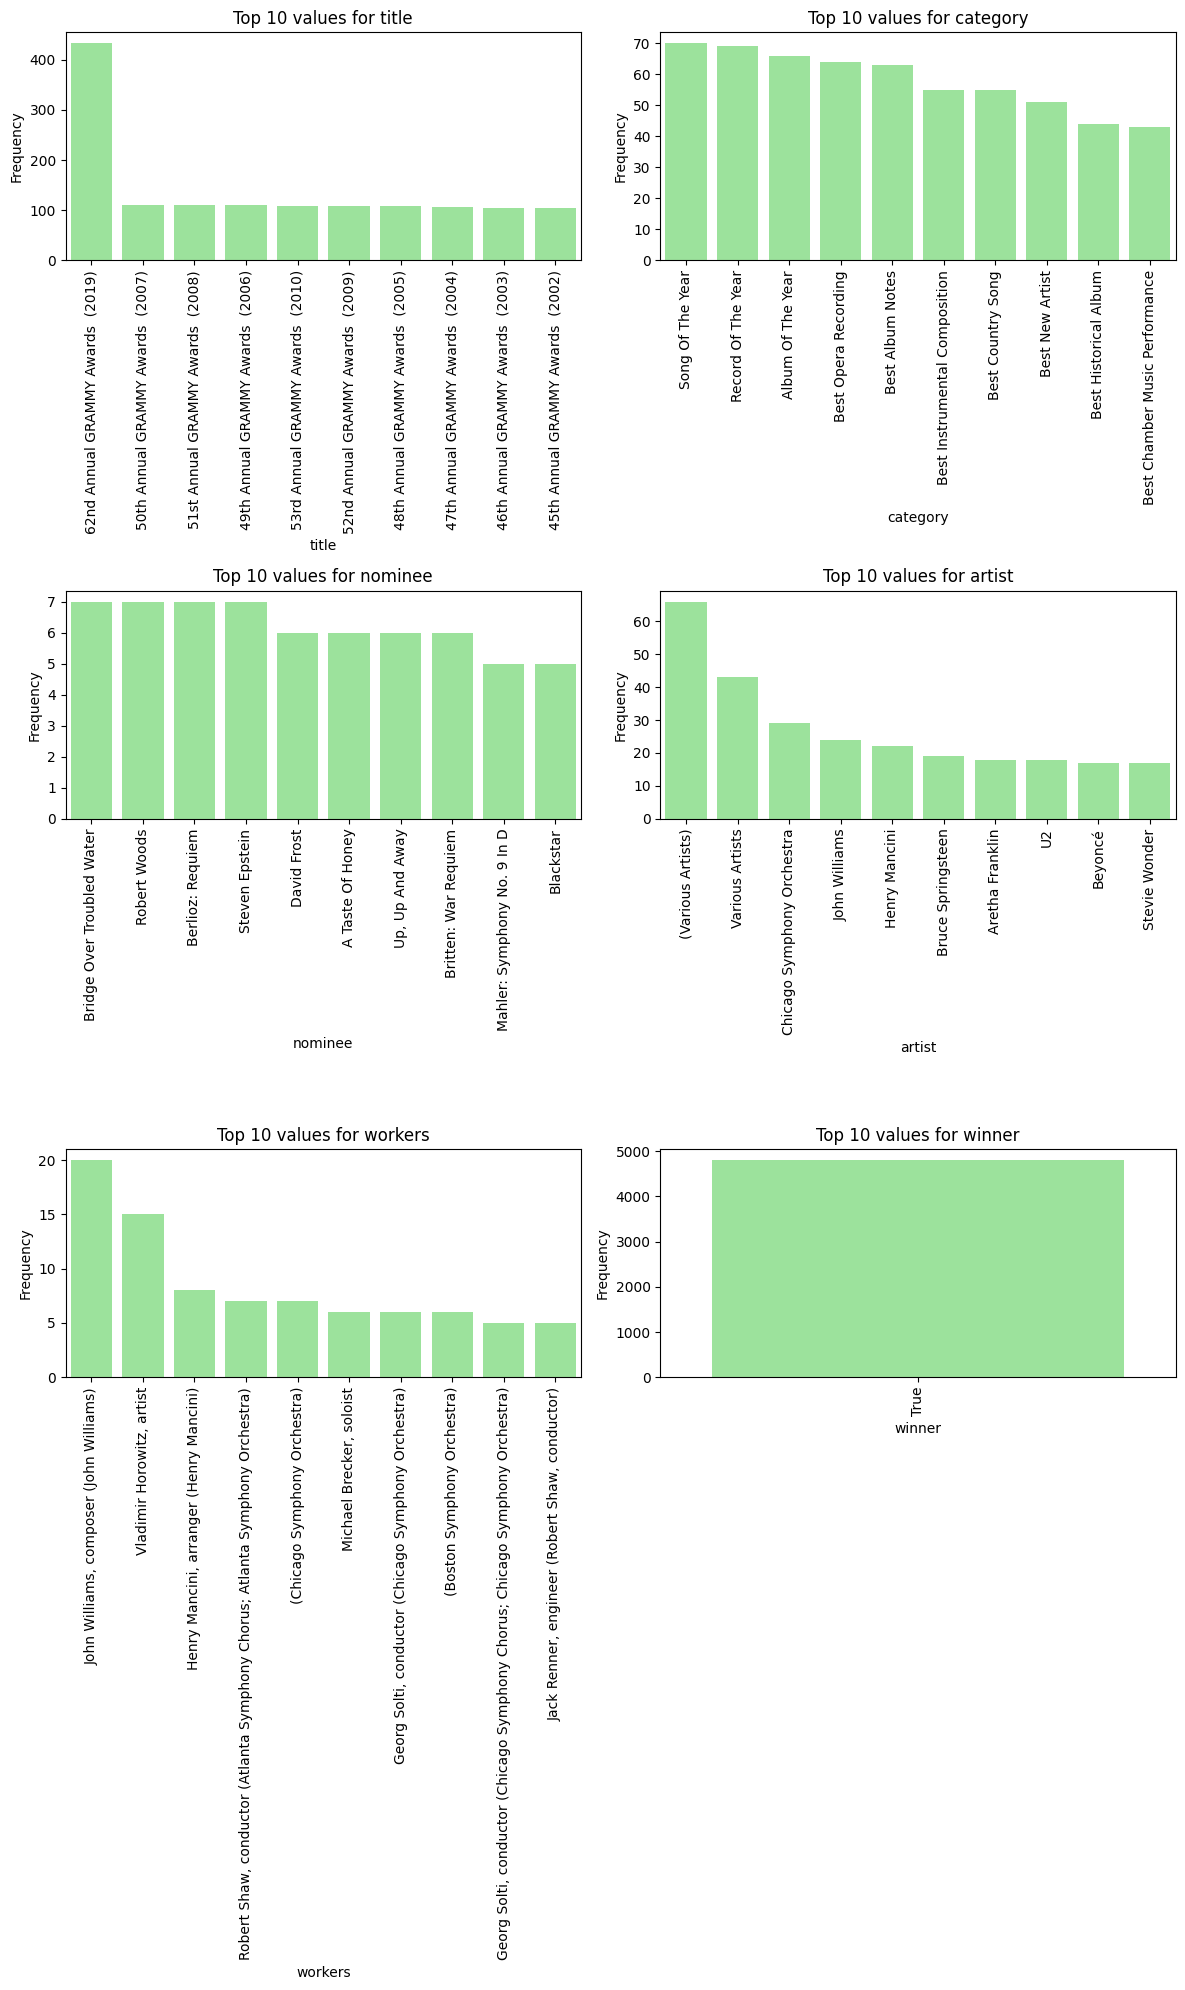

In [25]:
qualitative = df.select_dtypes(include=['object', 'bool']).columns
qualitative = qualitative[qualitative != 'img']

fig, axes = plt.subplots(3, 2, figsize=(12, 20))
axes = axes.flatten()

for i, col in enumerate(qualitative):
    top_counts = df[col].value_counts().head(10)

    top_df = pd.DataFrame({'Value': top_counts.index, 'Frequency': top_counts.values})
    
    sns.barplot(x='Value', y='Frequency', data=top_df, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Top 10 values for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=90) 

plt.tight_layout()
plt.show()

La columna winner solo tiene valores de True, aquí hay un error. Hay varios registros de la misma categoría en el mismo año. Sabemos que pueden haber empates entre dos personas, pero en este caso parecen ser el primer registro el ganador y los demás los nominados, esto lo confirmamos en la página oficial de los Grammy.

In [119]:
df[df['year']==2019]

,year,title,category,nominee,artist,workers,img,winner
0,2019,62Nd Annual Grammy Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, Producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62Nd Annual Grammy Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,"Bj Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62Nd Annual Grammy Awards (2019),Record Of The Year,7 Rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62Nd Annual Grammy Awards (2019),Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, Producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62Nd Annual Grammy Awards (2019),Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, Producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True
...,...,...,...,...,...,...,...,...
428,2019,62Nd Annual Grammy Awards (2019),Best Music Film,Homecoming,Beyoncé,"Beyoncé Knowles-Carter & Ed Burke, Video Direc...",https://www.grammy.com/sites/com/files/styles/...,True
429,2019,62Nd Annual Grammy Awards (2019),Best Music Film,Remember My Name,David Crosby,"A.J. Eaton, Video Director; Cameron Crowe, Mic...",https://www.grammy.com/sites/com/files/styles/...,True
430,2019,62Nd Annual Grammy Awards (2019),Best Music Film,Birth Of The Cool,(Miles Davis),"Stanley Nelson, Video Director; Nicole London,...",https://www.grammy.com/sites/com/files/styles/...,True
431,2019,62Nd Annual Grammy Awards (2019),Best Music Film,Shangri-La,(Various Artists),"Jeff Malmberg & Morgan Neville, Video Director...",https://www.grammy.com/sites/com/files/styles/...,True


Teniendo esto en cuenta, transformemos los que no fueron ganadores:

In [8]:
grouped = df.groupby(['year', 'title', 'category'])

for name, group in grouped:
    if len(group) > 2:
        df.loc[group.index[0], 'winner'] = True
        df.loc[group.index[1:], 'winner'] = False

Ahora, vemos que en realidad hay 7.3% de nominados que no fueron ganadores

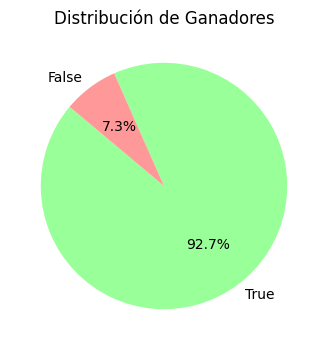

In [20]:
counts = df['winner'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#99FF99', '#FF9999'])
plt.title('Distribución de Ganadores')
plt.show()

Pero para nuestro análisis solo buscamos a los ganadores, por ende, eliminemos a aquellos que no lo fueron:

In [9]:
df = df[df['winner']== True]
df = df.reset_index(drop=True)

## Data Visualization

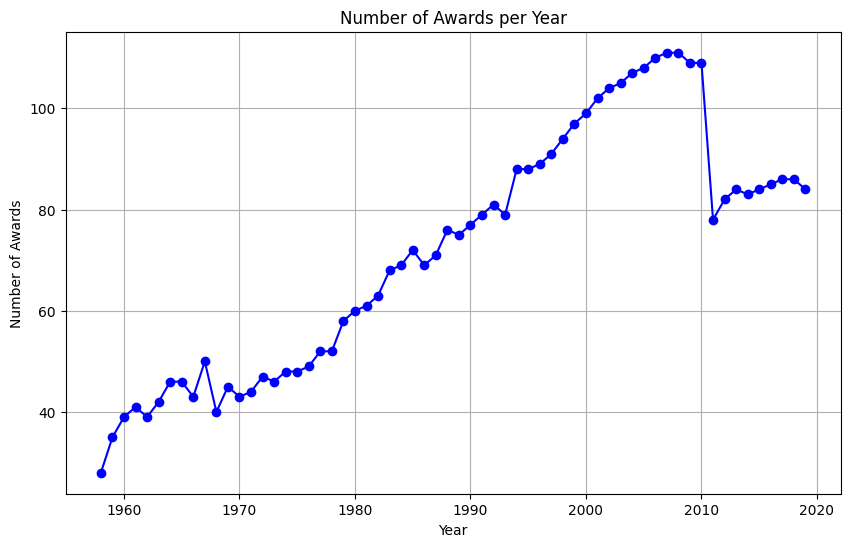

In [58]:
num_awards_per_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(num_awards_per_year.index, num_awards_per_year.values, marker='o', linestyle='-', color='b')

plt.xlabel('Year')
plt.ylabel('Number of Awards')
plt.title('Number of Awards per Year')
plt.grid(True)

plt.show()

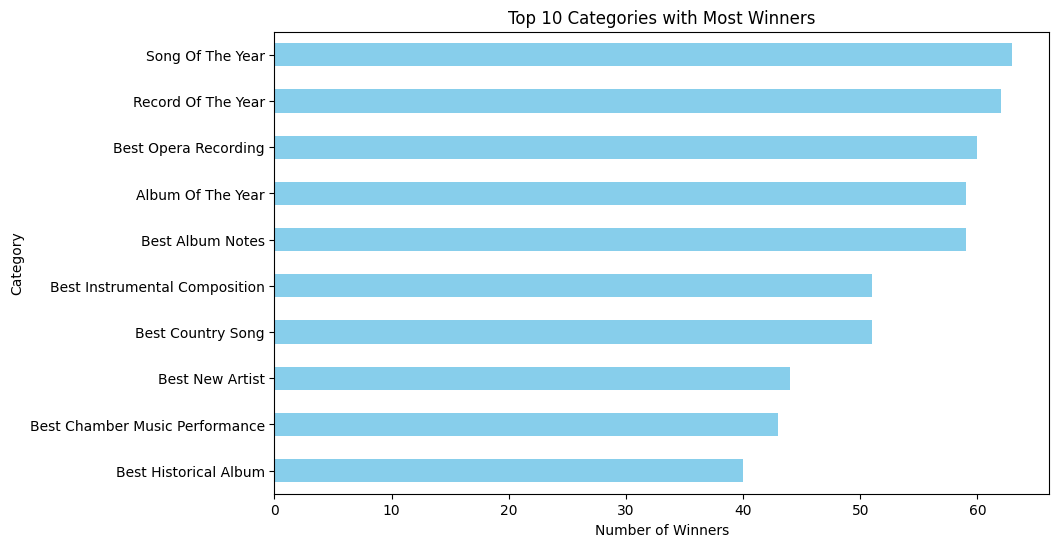

In [59]:
winners_df = df[df['winner'] == True]
top_categories_winners = winners_df['category'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_categories_winners.plot(kind='barh', color='skyblue')

plt.xlabel('Number of Winners')
plt.ylabel('Category')
plt.title('Top 10 Categories with Most Winners')
plt.gca().invert_yaxis()

plt.show()

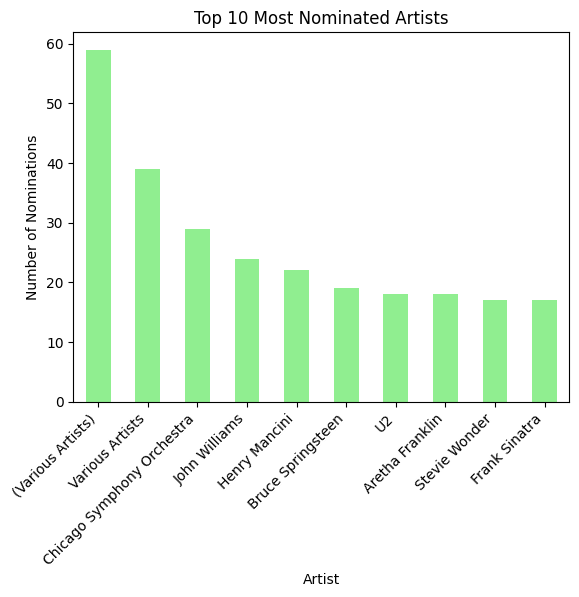

In [60]:
top_artists = df['artist'].value_counts().head(10)
top_artists.plot(kind='bar', color='lightgreen')
plt.xlabel('Artist')
plt.ylabel('Number of Nominations')
plt.title('Top 10 Most Nominated Artists')
plt.xticks(rotation=45, ha='right')
plt.show()

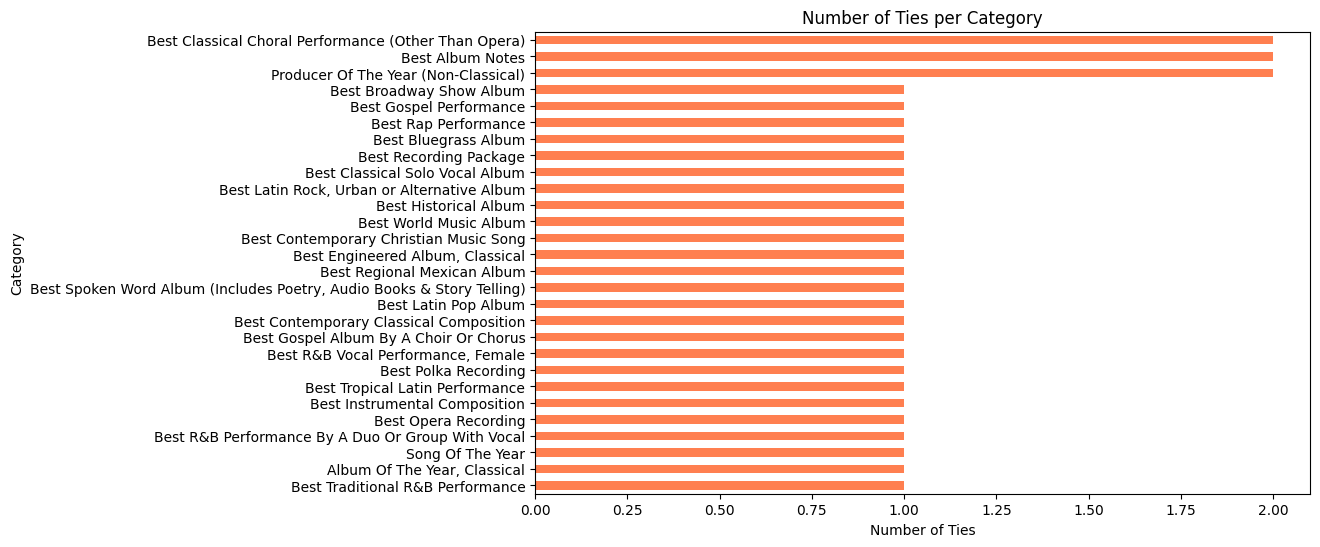

In [61]:
winner_count = df[df['winner']].groupby(['category', 'year']).size()
tie_results = winner_count[winner_count == 2].index 
df_tie_results = df[(df.set_index(['category', 'year']).index.isin(tie_results)) & (df['winner'] == True)].sort_values(by='year')
ties_per_category = df_tie_results['category'].value_counts() / 2

plt.figure(figsize=(10, 6))
ties_per_category.plot(kind='barh', color='coral')

plt.xlabel('Number of Ties')
plt.ylabel('Category')
plt.title('Number of Ties per Category')
plt.gca().invert_yaxis()  

plt.show()